In [14]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch

In [15]:
df = pd.read_csv('Real_Combine.csv')
df.head()

,T,TM,Tm,SLP,H,VV,V,VM,PM 2.5
0,7.4,9.8,4.8,1017.6,93.0,0.5,4.3,9.4,219.720833
1,7.8,12.7,4.4,1018.5,87.0,0.6,4.4,11.1,182.187500
2,6.7,13.4,2.4,1019.4,82.0,0.6,4.8,11.1,154.037500
3,8.6,15.5,3.3,1018.7,72.0,0.8,8.1,20.6,223.208333
4,12.4,20.9,4.4,1017.3,61.0,1.3,8.7,22.2,200.645833


In [16]:
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    1
dtype: int64

In [17]:
df = df.dropna()
df.isnull().sum()

T         0
TM        0
Tm        0
SLP       0
H         0
VV        0
V         0
VM        0
PM 2.5    0
dtype: int64

In [18]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [19]:
from keras.models import Sequential
from keras.layers import Flatten,Dense

In [20]:
def hyper_tune(hp):
    model = Sequential()
    for i in range(hp.Int('num_layers', 2, 20)):
        hp_units=hp.Int('Units_'+str(i), min_value=32, max_value=512, step=32)
        model.add(Dense(units=hp_units,activation='tanh'))
    model.add(Dense(1, activation='linear'))
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]) #0.01,0.001,0.0001
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_absolute_error',
                  metrics=['mean_absolute_error'])

    return model


In [21]:
tuner = RandomSearch(
    hyper_tune,
    objective='val_mean_absolute_error',
    max_trials=5,
    executions_per_trial=3,
    directory='project',
    overwrite=True,
    project_name='Air Quality Index AQI'
)


In [22]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(x,y, test_size=0.3, random_state =0)

In [23]:
tuner.search(x_train, y_train, epochs=5, validation_data=(x_test,y_test))

Trial 5 Complete [00h 00m 11s]
val_mean_absolute_error: 93.62572987874348

Best val_mean_absolute_error So Far: 65.32827758789062
Total elapsed time: 00h 01m 16s


In [24]:
import matplotlib.pyplot as plt

#Get the best Hyperparameters found during the search
best_hps = tuner.get_best_hyperparameters(1)[0]

#Build the Model with the best hyperparameters
model=hyper_tune(best_hps)

#Train the model with the best hyperparameters on the full training set
history = model.fit(x_train,y_train , epochs=5 ,validation_data = (x_test,y_test))



Epoch 1/5
24/24 [==============================] - 3s 23ms/step - loss: 75.2106 - mean_absolute_error: 75.2106 - val_loss: 65.6879 - val_mean_absolute_error: 65.6879
Epoch 2/5
24/24 [==============================] - 0s 12ms/step - loss: 66.6446 - mean_absolute_error: 66.6446 - val_loss: 66.5015 - val_mean_absolute_error: 66.5015
Epoch 3/5
24/24 [==============================] - 0s 10ms/step - loss: 66.2847 - mean_absolute_error: 66.2847 - val_loss: 65.2074 - val_mean_absolute_error: 65.2074
Epoch 4/5
24/24 [==============================] - 0s 11ms/step - loss: 66.2670 - mean_absolute_error: 66.2670 - val_loss: 65.5422 - val_mean_absolute_error: 65.5422
Epoch 5/5
24/24 [==============================] - 0s 11ms/step - loss: 66.4048 - mean_absolute_error: 66.4048 - val_loss: 65.6524 - val_mean_absolute_error: 65.6524


In [25]:
print(history.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


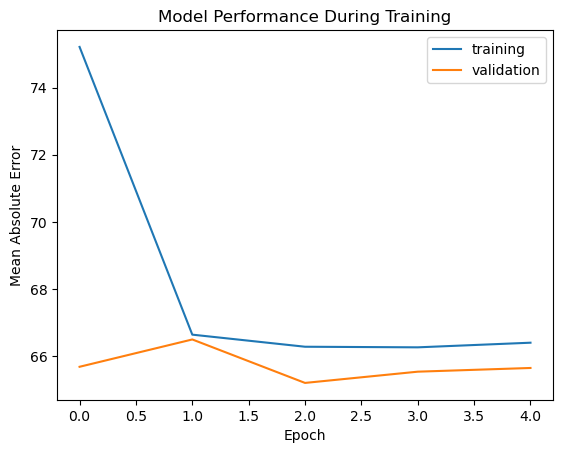

In [26]:
#Plot the Training and Validation Metrics for each Epoch
plt.plot(history.history['mean_absolute_error'] , label='training')
plt.plot(history.history['val_mean_absolute_error'] , label='validation')
plt.title('Model Performance During Training')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()